In [1]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=b4601e05b9dcb65071bb1eee0f8fd63e25fcef3c051631b598b865dc1046c43a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/alpaca-instructions-word-level-classification/train.csv')
df['instruction length'] = df['instruction'].str.len()
df['text length'] = df['text'].str.len()

df['python'] = df['instruction'].apply(lambda x: 'python' in x.lower())
print('python count: {}'.format(df['python'].sum()))
df['javascript'] = df['instruction'].apply(lambda x: 'js' in x.lower() or 'javascript' in x.lower())
print('javascript count: {}'.format(df['javascript'].sum()))
df['sql'] = df['instruction'].apply(lambda x: 'sql' in x.lower())
print('sql count: {}'.format(df['sql'].sum()))
df['ruby'] = df['instruction'].apply(lambda x: 'ruby' in x.lower())
print('ruby count: {}'.format(df['ruby'].sum()))
df['c++'] = df['instruction'].apply(lambda x: 'c++' in x.lower())
print('c++ count: {}'.format(df['c++'].sum()))
df['other'] = ~df[['python', 'javascript', 'sql', 'ruby', 'c++']].any(axis=1)
print('other count: {}'.format(df['other'].sum()))

# df = df.sample(frac=0.2, random_state=2023) # we need a sample for performance reasons

df = df[df['c++']] # let's just look at our C++ cluster

df.head()

python count: 17999
javascript count: 13172
sql count: 9170
ruby count: 1027
c++ count: 3510
other count: 77660


,input,instruction,text,output,instruction length,text length,python,javascript,sql,ruby,c++,other
2,NaN,Design a data structure in C++ to store inform...,Below is an instruction that describes a task....,#include <map>\n#include <string>\n\nclass Gro...,81,601,False,False,False,False,True,False
30,Not applicable,Design an object-oriented architecture for a g...,Below is an instruction that describes a task....,#include <iostream>\n\n//Define the base class...,57,1015,False,False,False,False,True,False
74,class MyClass {\npublic:\n\nprivate:\n};,Edit the given C++ class so that the copy cons...,Below is an instruction that describes a task....,class MyClass {\npublic:\n MyClass(const My...,65,322,False,False,False,False,True,False
138,Not applicable,Create a basic C++ console program for calcula...,Below is an instruction that describes a task....,#include <iostream>\n \nint main()\n{\n flo...,96,956,False,False,False,False,True,False
158,"sorted list: [2, 5, 8, 11, 19] \nnumber to sea...",Write a binary search algorithm in C++ to sear...,Below is an instruction that describes a task....,#include <iostream> \n \nusing namespace std;...,85,1188,False,False,False,False,True,False


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3510 entries, 2 to 121946
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   input               2417 non-null   object
 1   instruction         3510 non-null   object
 2   text                3510 non-null   object
 3   output              3510 non-null   object
 4   instruction length  3510 non-null   int64 
 5   text length         3510 non-null   int64 
 6   python              3510 non-null   bool  
 7   javascript          3510 non-null   bool  
 8   sql                 3510 non-null   bool  
 9   ruby                3510 non-null   bool  
 10  c++                 3510 non-null   bool  
 11  other               3510 non-null   bool  
dtypes: bool(6), int64(2), object(4)
memory usage: 212.5+ KB


In [4]:
df.nunique()

input                 1747
instruction           3505
text                  3510
output                3507
instruction length     194
text length           1106
python                   2
javascript               2
sql                      2
ruby                     1
c++                      1
other                    1
dtype: int64

In [5]:
from plotly.express import histogram
for column in [item for item in df.columns if item.endswith('length')]:
    histogram(data_frame=df, x=column, log_y=True).show()

In [6]:
from plotly.express import scatter
scatter(data_frame=df, x='text length', y='instruction length', log_x=True, log_y=True)

(-0.5, 1199.5, 1199.5, -0.5)

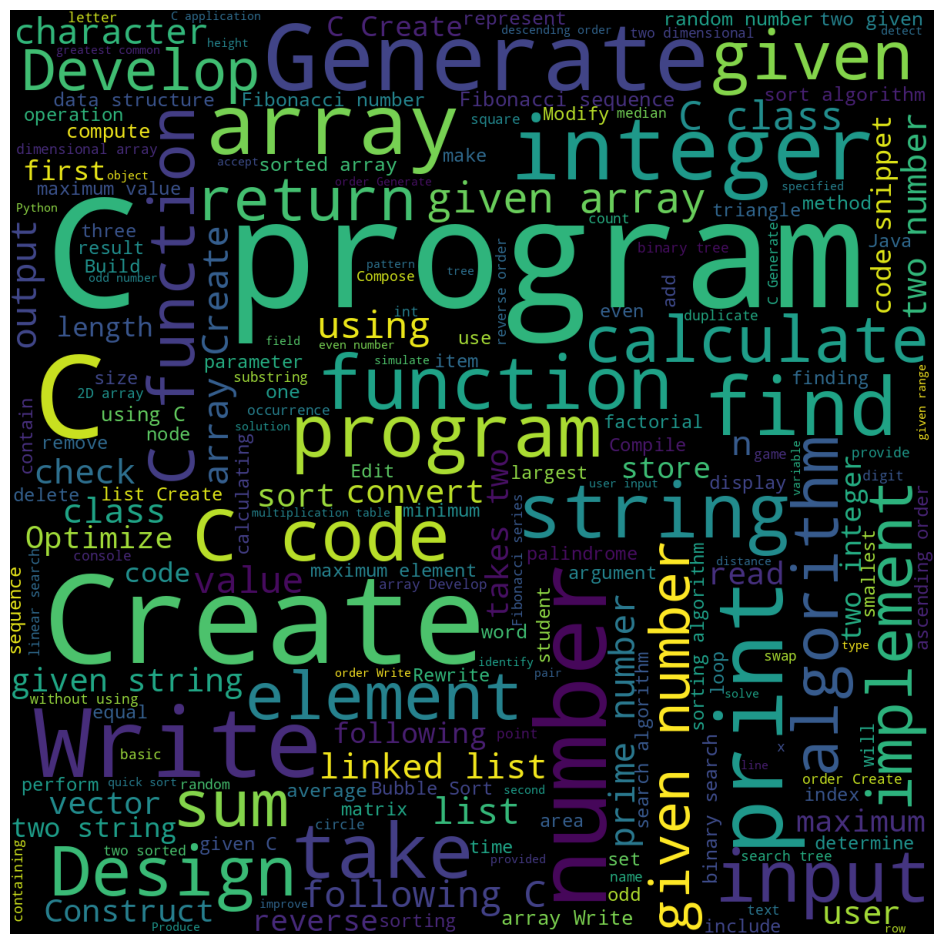

In [7]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 1.0
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=2023)['instruction'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS,).generate(text=text), )
axis('off')

In [8]:
# https://www.kaggle.com/code/ianalyticsgeek/keywords-extraction-using-bert
from arrow import now
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# we can't use more features than we can visualize
MAX_FEATURES = 100

NGRAM_RANGE = (1, 1)
model_start = now()
count = TfidfVectorizer(ngram_range=NGRAM_RANGE, stop_words='english', max_features=MAX_FEATURES,
                        min_df=0.01,
                        max_df=0.05,
                       ).fit(raw_documents=df['instruction'])
features = count.get_feature_names_out()
print('{}: got {} features'.format(now(), len(features)))

# add a feature prevalence counter using a CountVectorizer
feature_count = CountVectorizer(vocabulary=features).fit_transform(raw_documents=df['instruction'])

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
print('{}: built model'.format(now()))
# we need to encode the essays to get the words' relationships to each other
embedding = model.encode(df['instruction'].values.tolist())
print('{}: got embeddings'.format(now()))
feature_embeddings = model.encode(features)
print('{}: got feature embeddings'.format(now()))
print('model time: {}'.format(now() - model_start))

2023-12-06T16:34:45.562942+00:00: got 75 features


2023-12-06T16:34:51.412888+00:00: built model


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

2023-12-06T16:36:05.272311+00:00: got embeddings


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

2023-12-06T16:36:05.664307+00:00: got feature embeddings
model time: 0:01:20.187807


In [9]:
from plotly.express import bar
bar(data_frame=pd.DataFrame(data={'word': features, 'count': feature_count.toarray().sum(axis=0)}).sort_values(ascending=False, by='count').head(n=50),x='word', y='count')

In [10]:
# now we can project the feature vectors into 2-space to visualize 
from pandas import DataFrame
from plotly.express import scatter
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=2023, verbose=1, n_iter=10000, perplexity = min(50, len(features)-1))
tsne_df = DataFrame(data=tsne.fit_transform(X=feature_embeddings), columns=['t0', 't1'])
tsne_df['word'] = features
tsne_df['score'] = count.transform(features).toarray().sum(axis=0)
scatter(data_frame=tsne_df, x='t0', y='t1', text='word', hover_data=['score'], height=900, ).update_traces(marker={'size': 1})

[t-SNE] Computing 74 nearest neighbors...
[t-SNE] Indexed 75 samples in 0.001s...
[t-SNE] Computed neighbors for 75 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 75 / 75
[t-SNE] Mean sigma: 6.319100
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.575481
[t-SNE] KL divergence after 1300 iterations: 0.133801


We have chosen bigrams (2, 2) somewhat arbitrarily; TSNE spreads most of the values out so we can get a look at them. There are clues here that the keywords may not be evenly distributed across the corpus; let's take a quick look to see how the first word in our bigrams is distributed.

Let's try using UMAP to visualize the entire document landscape (of our sample) to see how our keywords represent the corpus.

In [11]:
from pandas import DataFrame
from plotly.express import scatter
from umap import UMAP
umap_model = UMAP(n_components=3, random_state=2023, verbose=1, init='pca', n_jobs=1)
umap_df = DataFrame(data=umap_model.fit_transform(X=embedding,), columns=['u0', 'u1', 'u2'])
umap_df['instruction'] = df['instruction'].values.tolist()
# scatter(data_frame=umap_df, x='u0', y='u1', color='u2', hover_name='instruction', height=900, ).show()
umap_feature_df = DataFrame(data=umap_model.transform(X=feature_embeddings,), columns=['u0', 'u1', 'u2'])
umap_feature_df['word'] = features
umap_feature_df['score'] = count.transform(features).toarray().sum(axis=0)
# scatter(data_frame=umap_feature_df, x='u0', y='u1', text='word', hover_data=['score'], height=900, ).update_traces(marker={'size': 1}).show()

UMAP(init='pca', n_components=3, n_jobs=1, random_state=2023, verbose=1)
Wed Dec  6 16:36:39 2023 Construct fuzzy simplicial set
Wed Dec  6 16:36:55 2023 Finding Nearest Neighbors
Wed Dec  6 16:37:00 2023 Finished Nearest Neighbor Search
Wed Dec  6 16:37:04 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec  6 16:37:12 2023 Finished embedding


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [12]:
from plotly.graph_objects import Figure
from plotly.graph_objects import Scatter
figure = Figure().update_layout(height=800)
figure.add_trace(Scatter(x=umap_df['u1'], y=umap_df['u2'], mode='markers', marker=dict(color=umap_df['u0'], colorscale='Peach'),
                        text=umap_df['instruction']))
figure.add_trace(Scatter(x=umap_feature_df['u1'], y=umap_feature_df['u2'], mode='text', text=umap_feature_df['word'], ))
figure.show()

Clearly we get 'islands' in our document landscape that bigrams don't represent particularly well: we have a Farenheit/Celcius island, a 3/three island, Ruby and React islands, and none of our keywords land there.